In [1]:
import pandas as pd
import pickle
import pywt, math
import statsmodels.api as sm
from tensorflow.keras.models import save_model
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.layers import Dropout
from kerastuner.tuners import BayesianOptimization
import random
import os
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras import regularizers
from pandas.plotting import lag_plot
from datetime import datetime
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LayerNormalization
from sklearn.metrics import r2_score
import time
from tensorflow.keras.utils import plot_model
from keras.regularizers import l1, l2
from tensorflow.keras.regularizers import l1_l2
from datetime import timedelta
from scipy.spatial import KDTree
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras.models import load_model
from IPython.display import Image
import keras_tuner as kt
from keras_tuner import RandomSearch
from keras.models import load_model
from sklearn.metrics import mean_squared_error
import scipy.io
from sklearn.model_selection import TimeSeriesSplit

C:\Users\VANKK\AppData\Local\Temp\ipykernel_17260\2645691637.py:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


In [2]:
path = "USD_CHF_RV_89_93.csv.zip"
df = pd.read_csv(f'{path}', compression = 'zip') 
rv = df.rvfx.values
r = np.flip(rv - np.mean(rv)) # Flip the data for convenience
test_size = 520
r_test = np.flip(r[:test_size]) # This corresponds to the last 520 observation (The most recent ones)
r = np.append(r, 0)
ts = np.arange(0, len(r))

In [3]:
c = 1/2
dec_lo, dec_hi, rec_lo, rec_hi = [c, c], [-c, c], [1, 1], [1, -1]
filter_bank = [dec_lo, dec_hi, rec_lo, rec_hi]
BandiWavelet = pywt.Wavelet(name="Bandi", filter_bank=filter_bank)

In [4]:
(A1, D1) = pywt.dwt(r, BandiWavelet)
(A2, D2) = pywt.dwt(A1, BandiWavelet)

# Creating the timestamps to making indexing more convenient
ts1 = np.arange(0, len(r), 2**1)
ts2 = np.arange(0, len(r), 2**2)

In [5]:
def bring_to_original_size(arr, j):

  # This function accepts the wavelet coefficients and depending on the scale
  # will return the wavelet coefficients that are of the same size as the
  # original realized volatility time series (3600), by filling zeros in between.

  output = np.array([])

  zeros_array = np.zeros(2**j-1)

  for i in range(len(arr)):

    output = np.append(output, arr[i])

    output = np.concatenate((output, zeros_array))

  return output

def adjust_size(A,D):

  # Since we model the scales using the other scales, for the j=3 coefficients
  # last 7 observations are 0s, for j=2 its 3 and for j=1 its 1. Hence the output
  # is the matrix of wavelet coefficients being all of the size of the coefficients
  # for j=3. Check the output.

  lengths = []

  for i in range(A.shape[1]):

      lengths.append(np.where(A[:,i] == A[:,i][A[:,i] != 0][-1])[0][0]+1)

  cutoff = np.min(lengths)

  A_output = A[:cutoff,:]
  D_output = D[:cutoff,:]

  return A_output, D_output

fA1 = bring_to_original_size(A1, 1)
fA2 = bring_to_original_size(A2, 2)
fD1 = bring_to_original_size(D1, 1)
fD2 = bring_to_original_size(D2, 2)

fA = np.column_stack((fA1,fA2))
fD = np.column_stack((fD1,fD2))
fA, fD = adjust_size(fA,fD)

# Creating the timestamps to making indexing more convenient
ts1 = np.arange(0, len(fA), 2**1)
ts2 = np.arange(0, len(fA), 2**2)

In [6]:
def new_create_direct_data(lags, rv = r):

    sample_length = np.min([len(fA[:-lags[0]*2,0]),len(fA[:-lags[1]*4,1]), len(fD[:-lags[2]*2,0]),len(fD[:-lags[3]*4,1])])
    X = np.empty((sample_length, np.sum(lags)))
    y = np.empty((sample_length,))

    for t in range(sample_length):

        ts1a_inds = ts1[ts1>t][:lags[0]]
        ts2a_inds = ts2[ts2>t][:lags[1]]
        ts1d_inds = ts1[ts1>t][:lags[2]]
        ts2d_inds = ts2[ts2>t][:lags[3]]
        X1a = fA[ts1a_inds,0]
        X2a = fA[ts2a_inds,1]
        X1d = fD[ts1d_inds,0]
        X2d = fD[ts2d_inds,1]
        X_row = np.concatenate((X1a,X2a,X1d,X2d,rv[t+1:t+1+lags[-1]]))
        X[t,:] = X_row
        y[t] = r[t]

    return np.flip(y), np.flip(X,0)

lags = [10,20,15,30,3]
y_dir, X_dir = new_create_direct_data(lags)

In [7]:
class MyHyperDirectModel(kt.HyperModel):

    def build(self, hp):

        model = Sequential()

        # pick activation function
        hp_act_func = hp.Choice('activation', values=['tanh','sigmoid','relu'])

        # Add input layer
        l2_reg = hp.Float('l2_regularization', min_value=0, max_value=0.3, step=0.01)
        l1_reg = hp.Float('l1_regularization', min_value=0, max_value=0.3, step=0.01)

        model.add(Dense(units=trainX.shape[1], activation=hp_act_func, input_dim=trainX.shape[1], kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))

        model.add(BatchNormalization())

        # Add hidden layers
        hp_units = 1000

        for i in range(hp.Int('num_layers', min_value=1, max_value=1, step=1)):

            l2_reg = hp.Float('l2_regularization_'+str(i), min_value=0, max_value=0.3, step=0.01)
            l1_reg = hp.Float('l1_regularization_'+str(i), min_value=0, max_value=0.3, step=0.01)

            hp_units = hp.Int('hidden_units_'+str(i), min_value=10, max_value=200, step=5)

            hp_act_func = hp.Choice('activation'+str(i), values=['tanh','sigmoid','relu'])

            model.add(Dense(units=hp_units, activation=hp_act_func, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))

            model.add(BatchNormalization())

        # Add output layer
        model.add(Dense(units=1, activation='linear'))

        hp_learning_rate = hp.Choice('learning_rate', values=[0.1, 0.01, 0.001, 0.0001, 0.00001, 0.05, 0.005, 0.00005])

        hp_weight_decay = hp.Choice('weight_decay', values=[0.0, 0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

        opt = tf.keras.optimizers.Adam(
                learning_rate=hp_learning_rate,
                name="Adam",weight_decay=hp_weight_decay)

        # Compile the model
        model.compile(optimizer=opt, loss='mse', metrics=["mean_absolute_error"])

        return model

    def fit(self, hp, model, x, y, validation_data, **kwargs):

        return model.fit(
            x,
            y,
            validation_data=validation_data,
            batch_size=hp.Choice("batch_size", [16, 32, 64, 128, 256]),
            epochs = hp.Int('epochs', min_value=200, max_value=300, step=10),
            **kwargs,
        )

        return history

In [8]:
from keras.callbacks import Callback
class BestValidationLossCallback(Callback):
    def __init__(self):
        super(BestValidationLossCallback, self).__init__()
        self.best_val_loss = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss is not None and val_loss < self.best_val_loss:
            self.best_val_loss = val_loss

    def on_train_end(self, logs=None):
        print('Best validation loss: {}'.format(self.best_val_loss))

In [9]:
def direct_tune_nn(training_X, training_y, validation_X, validation_y, iteration, trial):

        save_directory = f'Adaptive_tuning_with_true_rv/trial_{trial}/iter_{iteration}'

        max_trials = 50

        tuner = BayesianOptimization(MyHyperDirectModel(),
                objective='val_loss',
                num_initial_points=20,
                max_trials=max_trials,
                directory=save_directory,
                project_name=f'RV_forecasting',
                overwrite = True)

        callback = BestValidationLossCallback()

        tuner.search(training_X, training_y, validation_data = (validation_X, validation_y),callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3),callback],verbose = 0)
        
        best_model = tuner.get_best_models(1)[0]
        save_model(best_model, f'{save_directory}/model_{iteration}.h5')

        best_hps = tuner.get_best_hyperparameters(30)
        hp_directory = f'{save_directory}/hps_{iteration}.pkl'
        with open(hp_directory, 'wb') as file:
                pickle.dump(best_hps, file)
        
        return best_model, best_hps

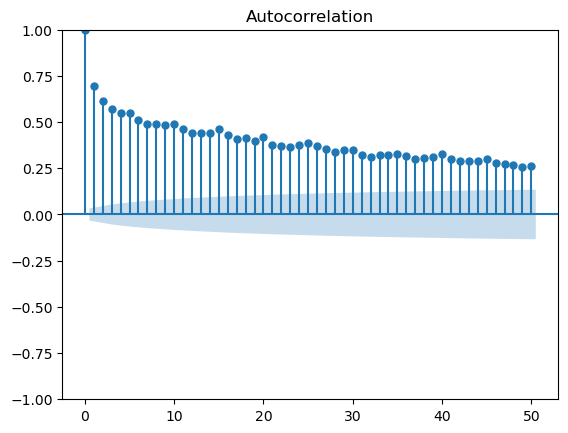

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

# Create the autocorrelation plot
plot_acf(r[:-1], lags=50)
plt.show()

In [12]:
trial = 1
lags = [30,30,30,30,30]
y_dir, X_dir = new_create_direct_data(lags)
batch_size = 44

In [35]:
val_ratio = 0.3
update_size = np.copy(test_size)
iteration = 1

while update_size > 0:
    
    print("Current update_size is ", update_size)

    test_y, test_X = y_dir[-update_size:], X_dir[-update_size:,:]
    full_train_y, full_train_X = y_dir[:-update_size], X_dir[:-update_size,:]
    
    val_size = int(len(full_train_y) * val_ratio)
    
    val_y, val_X = full_train_y[-val_size:], full_train_X[-val_size:,:]
    trainy, trainX = full_train_y[:-val_size], full_train_X[:-val_size,:]

    #Commented out just in case accidently ran it doesnt overwrite anything
    # model, hp = direct_tune_nn(trainX, trainy, val_X, val_y, iteration, trial)

    update_size = update_size - batch_size

    iteration = iteration + 1

Current update_size is  520
Best validation loss: 50.486026763916016
Best validation loss: 295.01605224609375
Best validation loss: 71.7395248413086
Best validation loss: 70.15675354003906
Best validation loss: 35.62321090698242
Best validation loss: 10.608604431152344
Best validation loss: 14.781051635742188
Best validation loss: 9.350902557373047
Best validation loss: 115.43124389648438
Best validation loss: 7.697574615478516
Best validation loss: 20.71280288696289
Best validation loss: 105.66630554199219
Best validation loss: 9.245436668395996
Best validation loss: 26.90032386779785
Best validation loss: 32.82749938964844
Best validation loss: 9.041642189025879
Best validation loss: 132.92840576171875
Best validation loss: 7.976064205169678
Best validation loss: 28.21409034729004
Best validation loss: 47.873409271240234
Best validation loss: 10.29751205444336
Best validation loss: 28.239744186401367
Best validation loss: 14.888525009155273
Best validation loss: 15.774447441101074
Be

C:\Users\VANKK\AppData\Local\Temp\ipykernel_4960\1998982945.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iteration}.h5')


Current update_size is  476
Best validation loss: 46.30104446411133
Best validation loss: 12.256786346435547
Best validation loss: 60.20270919799805
Best validation loss: 9.27994441986084
Best validation loss: 20.946147918701172
Best validation loss: 43.379024505615234
Best validation loss: 19.75223159790039
Best validation loss: 13.919013977050781
Best validation loss: 17.235097885131836
Best validation loss: 14.157350540161133
Best validation loss: 13.839407920837402
Best validation loss: 18.517099380493164
Best validation loss: 19.260040283203125
Best validation loss: 15.69079875946045
Best validation loss: 8.550228118896484
Best validation loss: 16.06166648864746
Best validation loss: 16.50423812866211
Best validation loss: 154.67481994628906
Best validation loss: 58.52935791015625
Best validation loss: 425.52471923828125
Best validation loss: 8.492008209228516
Best validation loss: 7.9407525062561035


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 15.919370651245117


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 31.11107063293457


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 17.818675994873047


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 9.556970596313477


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 20.633935928344727


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 15.141663551330566


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 8.89677906036377
Best validation loss: 32.80755615234375
Best validation loss: 8.95377254486084


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 65.16292572021484
Best validation loss: 31.09592056274414
Best validation loss: 18.84001922607422
Best validation loss: 10.768845558166504


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 56.68617630004883


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 22.982011795043945


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 51.55134201049805


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 17.515857696533203


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 13.670331001281738


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 42.241172790527344


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 17.222400665283203


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 20.517742156982422


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 9.384902000427246


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 67.61637878417969


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 15.332598686218262


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 8.10023021697998


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 51.120792388916016


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 43.39907455444336


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 23.340362548828125
INFO:tensorflow:Oracle triggered exit


C:\Users\VANKK\AppData\Local\Temp\ipykernel_4960\1998982945.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iteration}.h5')


Current update_size is  432
Best validation loss: 18.29999351501465
Best validation loss: 41.25393295288086
Best validation loss: 153.78602600097656
Best validation loss: 52.98677444458008
Best validation loss: 327.94830322265625
Best validation loss: 12.43316650390625
Best validation loss: 9.32078742980957
Best validation loss: 15.476105690002441
Best validation loss: 25.327861785888672
Best validation loss: 83.68888854980469
Best validation loss: 99.0674819946289
Best validation loss: 147.12310791015625
Best validation loss: 15.524938583374023
Best validation loss: 22.416091918945312
Best validation loss: 78.51005554199219
Best validation loss: 103.29713439941406
Best validation loss: 17.99585723876953
Best validation loss: 145.72314453125
Best validation loss: 22.56087875366211
Best validation loss: 108.03840637207031


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 9.06833267211914


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 61.523460388183594


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 87.82646179199219


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 24.706106185913086
Best validation loss: 21.450227737426758
Best validation loss: 10.896987915039062
Best validation loss: 9.725419044494629
Best validation loss: 9.517147064208984
Best validation loss: 49.90281295776367
Best validation loss: 19.317249298095703
Best validation loss: 13.4049072265625
Best validation loss: 25.25373649597168
Best validation loss: 8.106738090515137
Best validation loss: 16.386594772338867
Best validation loss: 25.82465362548828
Best validation loss: 15.310450553894043
Best validation loss: 521.9542846679688
Best validation loss: 9.684551239013672
Best validation loss: 13.531414985656738
Best validation loss: 31.374738693237305
Best validation loss: 25.882043838500977
Best validation loss: 15.281070709228516
Best validation loss: 15.97037124633789
Best validation loss: 14.700843811035156
Best validation loss: 8.728965759277344
Best validation loss: 16.465646743774414
Best validation loss: 11.486239433288574
Best validation loss: 17.756

C:\Users\VANKK\AppData\Local\Temp\ipykernel_4960\1998982945.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iteration}.h5')


Current update_size is  388
Best validation loss: 9.991387367248535
Best validation loss: 11.647441864013672
Best validation loss: 12.608803749084473
Best validation loss: 8.723408699035645
Best validation loss: 13.320499420166016
Best validation loss: 111.34894561767578
Best validation loss: 86.4439697265625
Best validation loss: 99.98970794677734
Best validation loss: 29.12984275817871
Best validation loss: 18.097116470336914
Best validation loss: 41.95135498046875
Best validation loss: 48.236045837402344
Best validation loss: 28.542694091796875
Best validation loss: 58.21113967895508
Best validation loss: 13.732373237609863
Best validation loss: 18.448606491088867
Best validation loss: 43.07333755493164
Best validation loss: 6.89773416519165
Best validation loss: 17.339317321777344
Best validation loss: 16.43063735961914


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 26.646512985229492


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 10.533613204956055


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 19.187345504760742


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 54.13720703125


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 7.212155342102051


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 151.5828857421875


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 24.99686622619629


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 9.477728843688965


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 25.569602966308594


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 343.32440185546875


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 340.3544616699219


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 11.751226425170898


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 16.705915451049805


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 7.413329124450684


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 14.345422744750977


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 14.918208122253418


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 12.005411148071289


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 81.0003890991211


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 55.26869583129883


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 71.09619903564453


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 8.504289627075195


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 13.960601806640625


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 100.36931610107422


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 12.444368362426758


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 14.3656005859375


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 10.996980667114258


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 19.057405471801758


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 27.269412994384766


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 14.33767032623291


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 95.87046813964844
INFO:tensorflow:Oracle triggered exit


C:\Users\VANKK\AppData\Local\Temp\ipykernel_4960\1998982945.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iteration}.h5')


Current update_size is  344
Best validation loss: 36.38749313354492
Best validation loss: 46.214603424072266
Best validation loss: 50.03291320800781
Best validation loss: 41.03703308105469
Best validation loss: 38.91205596923828
Best validation loss: 7.110857009887695
Best validation loss: 83.08991241455078
Best validation loss: 36.82240676879883
Best validation loss: 11.248457908630371
Best validation loss: 9.732219696044922
Best validation loss: 121.05493927001953
Best validation loss: 20.335298538208008
Best validation loss: 12.920064926147461
Best validation loss: 93.01748657226562
Best validation loss: 50.146114349365234
Best validation loss: 56.416969299316406
Best validation loss: 8.052022933959961
Best validation loss: 19.930706024169922
Best validation loss: 27.543718338012695
Best validation loss: 16.74648666381836
Best validation loss: 6.795771598815918
Best validation loss: 29.005399703979492
Best validation loss: 9.742831230163574
Best validation loss: 15.364335060119629
B

C:\Users\VANKK\AppData\Local\Temp\ipykernel_4960\1998982945.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iteration}.h5')


Current update_size is  300
Best validation loss: 10.55203914642334
Best validation loss: 218.8269500732422
Best validation loss: 24.191152572631836
Best validation loss: 22.745500564575195
Best validation loss: 215.4993133544922
Best validation loss: 105.38336944580078
Best validation loss: 6.898407936096191
Best validation loss: 66.66592407226562
Best validation loss: 8.673294067382812
Best validation loss: 18.823091506958008
Best validation loss: 330.50244140625
Best validation loss: 57.93412780761719
Best validation loss: 8.815978050231934
Best validation loss: 14.28915786743164
Best validation loss: 9.446764945983887
Best validation loss: 14.558141708374023
Best validation loss: 88.0158462524414
Best validation loss: 27.12936782836914
Best validation loss: 95.59476470947266
Best validation loss: 16.430419921875
Best validation loss: 9.503997802734375
Best validation loss: 50.26320266723633
Best validation loss: 11.361480712890625
Best validation loss: 21.997575759887695
Best valid

C:\Users\VANKK\AppData\Local\Temp\ipykernel_4960\1998982945.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iteration}.h5')


Current update_size is  256
Best validation loss: 6.541569232940674
Best validation loss: 53.486331939697266
Best validation loss: 623.625
Best validation loss: 6.545614719390869
Best validation loss: 13.687503814697266
Best validation loss: 11.40926456451416
Best validation loss: 8.077923774719238
Best validation loss: 66.1259994506836
Best validation loss: 6.757272243499756
Best validation loss: 7.179727077484131
Best validation loss: 129.0155487060547
Best validation loss: 27.568193435668945
Best validation loss: 11.155974388122559
Best validation loss: 11.713994979858398
Best validation loss: 31.607040405273438
Best validation loss: 7.8221564292907715
Best validation loss: 7.49185037612915
Best validation loss: 79.19715881347656
Best validation loss: 10.235284805297852
Best validation loss: 14.502788543701172
Best validation loss: 16.042842864990234
Best validation loss: 68.82740020751953
Best validation loss: 116.03943634033203
Best validation loss: 8.552630424499512
Best validati

C:\Users\VANKK\AppData\Local\Temp\ipykernel_4960\1998982945.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iteration}.h5')


Current update_size is  212
Best validation loss: 26.098087310791016
Best validation loss: 46.324764251708984
Best validation loss: 15.144819259643555
Best validation loss: 55.074317932128906
Best validation loss: 219.6585235595703
Best validation loss: 22.468189239501953
Best validation loss: 22.963666915893555
Best validation loss: 209.21087646484375
Best validation loss: 106.33942413330078
Best validation loss: 6.89703893661499
Best validation loss: 67.42037200927734
Best validation loss: 8.584004402160645
Best validation loss: 21.303647994995117
Best validation loss: 328.5869140625
Best validation loss: 54.50959396362305
Best validation loss: 9.857536315917969
Best validation loss: 16.547422409057617
Best validation loss: 10.186001777648926
Best validation loss: 11.937867164611816
Best validation loss: 78.734375


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 20.121009826660156


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 170.22972106933594


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 21.14159393310547


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 13.332609176635742


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 10.619277954101562


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 11.481163024902344


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 48.71352767944336


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 27.665843963623047


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 20.551862716674805


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 17.176729202270508


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 52.74812316894531


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 126.1473388671875


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 235.39706420898438


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 52.32609176635742


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 14.66283893585205


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 92.03123474121094


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 11.152756690979004


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 41.86344909667969


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 50.59984588623047


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 15.82374382019043


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 13.291537284851074


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 18.00145149230957


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 30.784326553344727


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 21.124643325805664


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 7.64549446105957


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 14.247516632080078


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 21.370006561279297


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 53.73814010620117


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 10.125955581665039


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 15.607453346252441
INFO:tensorflow:Oracle triggered exit


C:\Users\VANKK\AppData\Local\Temp\ipykernel_4960\1998982945.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iteration}.h5')


Current update_size is  168
Best validation loss: 12.641617774963379
Best validation loss: 69.48957061767578
Best validation loss: 8.844889640808105
Best validation loss: 18.93250846862793
Best validation loss: 119.94342041015625
Best validation loss: 19.797842025756836
Best validation loss: 188.23544311523438
Best validation loss: 10.226682662963867
Best validation loss: 9.880929946899414
Best validation loss: 14.048698425292969
Best validation loss: 11.777469635009766
Best validation loss: 171.9840850830078
Best validation loss: 8.699006080627441
Best validation loss: 6.8752055168151855
Best validation loss: 8.906556129455566
Best validation loss: 35.138954162597656
Best validation loss: 88.68692016601562
Best validation loss: 93.65127563476562
Best validation loss: 18.83784294128418
Best validation loss: 19.953283309936523
Best validation loss: 10.073331832885742
Best validation loss: 7.12123441696167
Best validation loss: 8.179718017578125
Best validation loss: 50.178062438964844
B

C:\Users\VANKK\AppData\Local\Temp\ipykernel_4960\1998982945.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iteration}.h5')


Current update_size is  124
Best validation loss: 11.244423866271973
Best validation loss: 84.54618835449219
Best validation loss: 44.2772331237793
Best validation loss: 18.34996223449707
Best validation loss: 15.957308769226074
Best validation loss: 15.149781227111816
Best validation loss: 13.750012397766113
Best validation loss: 11.489431381225586
Best validation loss: 9.576677322387695
Best validation loss: 520.3269653320312
Best validation loss: 6.274572372436523
Best validation loss: 22.39958381652832
Best validation loss: 70.078857421875
Best validation loss: 10.642234802246094
Best validation loss: 13.575582504272461
Best validation loss: 17.400182723999023
Best validation loss: 26.890308380126953
Best validation loss: 8.632720947265625
Best validation loss: 28.707857131958008
Best validation loss: 12.047192573547363
Best validation loss: 30.83791732788086
Best validation loss: 6.60959529876709
Best validation loss: 35.86695098876953
Best validation loss: 7.788852691650391
Best 

C:\Users\VANKK\AppData\Local\Temp\ipykernel_4960\1998982945.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iteration}.h5')


Current update_size is  80
Best validation loss: 9.442554473876953
Best validation loss: 172.00340270996094
Best validation loss: 51.61000061035156
Best validation loss: 7.692534923553467
Best validation loss: 60.924835205078125
Best validation loss: 11.37279987335205
Best validation loss: 9.700550079345703
Best validation loss: 50.63015365600586
Best validation loss: 6.319432258605957
Best validation loss: 83.66460418701172
Best validation loss: 381.39935302734375
Best validation loss: 136.44525146484375
Best validation loss: 12.746805191040039
Best validation loss: 16.470582962036133
Best validation loss: 12.836201667785645
Best validation loss: 57.508140563964844
Best validation loss: 14.714736938476562
Best validation loss: 8.081864356994629
Best validation loss: 13.98234748840332
Best validation loss: 10.221941947937012
Best validation loss: 9.757129669189453
Best validation loss: 14.037941932678223
Best validation loss: 7.437300205230713
Best validation loss: 66.03223419189453
Be

C:\Users\VANKK\AppData\Local\Temp\ipykernel_4960\1998982945.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iteration}.h5')


Current update_size is  36
Best validation loss: 44.99627685546875
Best validation loss: 31.978818893432617
Best validation loss: 12.444380760192871
Best validation loss: 274.3046875
Best validation loss: 20.84929084777832
Best validation loss: 14.492507934570312
Best validation loss: 21.555784225463867
Best validation loss: 98.299560546875
Best validation loss: 187.20648193359375
Best validation loss: 19.751710891723633
Best validation loss: 16.865413665771484
Best validation loss: 154.1402587890625
Best validation loss: 13.633076667785645
Best validation loss: 8.444098472595215
Best validation loss: 6.314037799835205
Best validation loss: 11.51443099975586
Best validation loss: 49.093807220458984
Best validation loss: 21.3565673828125
Best validation loss: 20.8831729888916
Best validation loss: 63.35041427612305


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 5.920797824859619


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 17.297700881958008


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 51.27291488647461


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 49.65864562988281


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 8.048258781433105


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 15.120713233947754


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 36.17388916015625


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 6.926183700561523


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 27.493061065673828


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 8.799553871154785


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 85.92835998535156


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 89.59349822998047


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 95.99266052246094


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 6.750199317932129


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 18.698516845703125


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 8.338593482971191


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 44.969886779785156


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 11.330597877502441


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 62.41743087768555


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 7.168688774108887


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 31.41956901550293


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 61.278289794921875


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 11.081448554992676


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 12.30716323852539


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 6.752259254455566


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 11.28524112701416


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 17.801015853881836


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 67.28961181640625


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 19.399328231811523


C:\Users\VANKK\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Best validation loss: 9.97364616394043
INFO:tensorflow:Oracle triggered exit


C:\Users\VANKK\AppData\Local\Temp\ipykernel_4960\1998982945.py:20: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(best_model, f'{save_directory}/model_{iteration}.h5')


In [10]:
update_amount = int(np.floor(test_size/batch_size))

models = {}

trial = 1

for iteration in range(1,13):

    models[iteration] = load_model(f'Adaptive_tuning_with_true_rv/trial_{trial}/iter_{iteration}/model_{iteration}.h5')

NameError: name 'batch_size' is not defined

In [15]:
test_y, test_X = y_dir[-test_size:], X_dir[-test_size:,:]

batches = int(np.floor(test_size/batch_size))

predictions = np.array([])

for i in range(batches):
    
    if i < batches-1:
        inds = np.arange(0+batch_size*(i),batch_size + batch_size*(i))
    else: 
        inds = np.arange(0+batch_size*(i),test_size)
        
    batch_y = test_y[inds]
    batch_X = test_X[inds,:]
    
    preds = models[i+1].predict(batch_X, verbose = 0)
    
    predictions = np.append(predictions, preds)
        
print("MSE = ", mean_squared_error(r_test, predictions))
print("MAE = ", mean_absolute_error(r_test, predictions))
print("R2 = ", r2_score(r_test, predictions))

MSE =  3.430689156043259
MAE =  1.4235079755936713
R2 =  0.7329663997736553


In [16]:
print("MSE = ", mean_squared_error(r_test, predictions))
print("MAE = ", mean_absolute_error(r_test, predictions))
print("R2 = ", r2_score(r_test, predictions))

MSE =  3.430689156043259
MAE =  1.4235079755936713
R2 =  0.7329663997736553


In [18]:
val_ratio = 0.3
update_size = np.copy(test_size)
iteration = 1 

old_model = models[iteration]
old_model_ind = 1

model_iter_counter = []

while update_size > 0:
    
    print("Current update_size is ", update_size)

    test_y, test_X = y_dir[-update_size:], X_dir[-update_size:,:]
    full_train_y, full_train_X = y_dir[:-update_size], X_dir[:-update_size,:]
    
    val_size = int(len(full_train_y) * val_ratio)
    
    val_y, val_X = full_train_y[-val_size:], full_train_X[-val_size:,:]
    trainy, trainX = full_train_y[:-val_size], full_train_X[:-val_size,:]
    
    new_model = models[iteration]
    new_preds = new_model.predict(val_X, verbose = 0)
    new_mse = mean_squared_error(val_y, new_preds)
    
    if iteration == 1:
        
        model_iter_counter.append([iteration, iteration])

    else: 
        
        old_preds = old_model.predict(val_X, verbose = 0)
        old_mse = mean_squared_error(val_y, old_preds)
        
        if old_mse < new_mse:
            
            model_iter_counter.append([iteration, old_model_ind])
        
        else: 
            
            old_model_ind = iteration 
            model_iter_counter.append([iteration, iteration])

    update_size = update_size - batch_size

    iteration = iteration + 1

Current update_size is  520
Current update_size is  476
Current update_size is  432
Current update_size is  388
Current update_size is  344
Current update_size is  300
Current update_size is  256
Current update_size is  212
Current update_size is  168
Current update_size is  124
Current update_size is  80
Current update_size is  36


In [19]:
test_y, test_X = y_dir[-test_size:], X_dir[-test_size:,:]

batches = int(np.floor(test_size/batch_size))

predictions = np.array([])

iteration = 1

obs_counter = 0

for i in range(0, test_size):
    
    X_row = test_X[-test_size + i,:].reshape((1,-1))
    
    model_ind = model_iter_counter[iteration - 1][1]
    model = models[model_ind]
    
    prediction = model.predict(X_row,verbose = 0)
    
    predictions = np.append(predictions, prediction)
    
    obs_counter += 1
    
    if obs_counter % batch_size == 0: 
        
        iteration += 1

3.4440814814131686


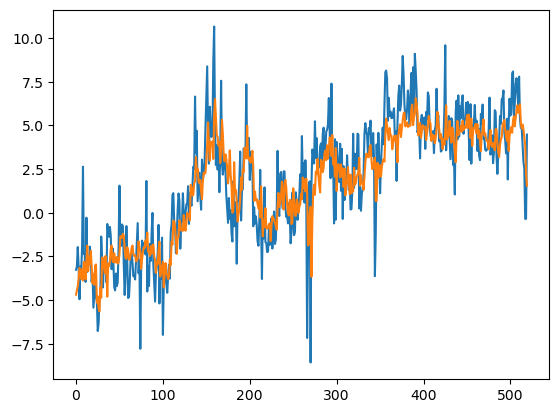

In [20]:
plt.plot(r_test)
plt.plot(predictions)
print(mean_squared_error(r_test, predictions))

In [14]:
def direct_horizon_prediction(horizon, lags, models, batch_size, rv = r, test_size = test_size):

    forecasts_size = test_size - horizon + 1

    horizon_forecasts_direct = np.array([])

    iteration = 1

    obs_counter = 0

    model = models[iteration]

    for j in range(51, -1, -1):
        
        print(f'Predicting {j}')

        t = j
        T = t + horizon

        find_values = np.flip(np.arange(t,T))

        pred_and_trues = np.copy(r)
        pred_and_trues[:T] = 0

        new_fA = np.copy(fA)
        new_fA[ts1[ts1 < T],0] = 0
        new_fA[ts2[ts2 < T],1] = 0

        new_fD = np.copy(fD)
        new_fD[ts1[ts1 < T],0] = 0
        new_fD[ts2[ts2 < T],1] = 0

        counter = T
        temp_predictions = np.array([])

        for i in range(len(find_values)):

            y_ind = find_values[i]
            X_ind_1 = ts1[(ts1 > y_ind)*(ts1 >= counter)]
            X_ind_2 = ts2[(ts2 > y_ind)*(ts2 >= counter)]
            X = np.concatenate((new_fA[X_ind_1[:lags[0]],0],new_fA[X_ind_2[:lags[1]],1],new_fD[X_ind_1[:lags[2]],0],new_fD[X_ind_2[:lags[3]],1], pred_and_trues[counter:counter+lags[-1]])).reshape(1, -1)
            y_hat = model.predict(X, verbose = 0)
            temp_predictions = np.append(temp_predictions, y_hat)

            pred_and_trues[y_ind] = y_hat

            if y_ind in ts1:
                new_fA[int(y_ind/2),0], new_fD[int(y_ind/2),0] =  pywt.dwt(pred_and_trues[y_ind:y_ind+2], BandiWavelet)
            if y_ind in ts2:
                new_fA[int(y_ind/4),1], new_fD[int(y_ind/4),1] =  pywt.dwt(pywt.dwt(pred_and_trues[y_ind:y_ind+4], BandiWavelet)[0], BandiWavelet)

            counter = counter - 1

        horizon_forecasts_direct = np.append(horizon_forecasts_direct, temp_predictions[-1])

        obs_counter += 1

        if obs_counter % batch_size == 0:

            iteration += 1

            model = models[iteration]
            
        lm_save_path = f'prediction/direct_nn_{horizon}_last_51.pkl'

        os.makedirs(os.path.dirname(lm_save_path), exist_ok=True)

        with open(lm_save_path, 'wb') as file:
            pickle.dump(horizon_forecasts_direct, file)

    return horizon_forecasts_direct

In [16]:
horizons = [1,5,20,60]

for hor in horizons:

    preds = direct_horizon_prediction(hor, lags, models, batch_size)

    lm_save_path = f'prediction/direct_nn_{hor}.pkl'

    os.makedirs(os.path.dirname(lm_save_path), exist_ok=True)

    print(f'Done with horizon {hor}')
    print(f'{mean_squared_error(r_test[hor-1:],preds)}')

    with open(lm_save_path, 'wb') as file:
        pickle.dump(preds, file)

Predicting 51
Predicting 50
Predicting 49
Predicting 48
Predicting 47
Predicting 46
Predicting 45
Predicting 44
Predicting 43
Predicting 42
Predicting 41
Predicting 40
Predicting 39
Predicting 38
Predicting 37
Predicting 36
Predicting 35
Predicting 34
Predicting 33
Predicting 32
Predicting 31
Predicting 30
Predicting 29
Predicting 28
Predicting 27
Predicting 26
Predicting 25
Predicting 24
Predicting 23
Predicting 22
Predicting 21
Predicting 20
Predicting 19
Predicting 18
Predicting 17
Predicting 16
Predicting 15
Predicting 14
Predicting 13
Predicting 12
Predicting 11
Predicting 10
Predicting 9
Predicting 8
Predicting 7
Predicting 6
Predicting 5
Predicting 4
Predicting 3
Predicting 2
Predicting 1
Predicting 0
